In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils import load, plot_sample, train, train_cnn, prepare_submission

from datetime import datetime
import os
import time

import matplotlib.pyplot as pyplot
import tensorflow as tf

In [4]:
os.environ["FTRAIN"] = "/Users/chang12/projects/kaggle/facial-keypoint-detection/training.csv"
os.environ["FTEST"] = "/Users/chang12/projects/kaggle/facial-keypoint-detection/test.csv"

In [4]:
X, y = load()
X_test, _ = load(test=True)

print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(X.shape, X.min(), X.max()))
print("X_test.shape == {}; X_test.min == {:.3f}; X_test.max == {:.3f}".format(X_test.shape, X_test.min(), X_test.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(y.shape, y.min(), y.max()))

X.shape == (2140, 9216); X.min == 0.000; X.max == 1.000
X_test.shape == (1783, 9216); X_test.min == 0.000; X_test.max == 1.000
y.shape == (2140, 30); y.min == -0.920; y.max == 0.996


In [11]:
num_epoch = 1000
name = "cnn_with_saver"

y_pred = train_cnn(num_epoch, X, y, X_test, name)

Epoch:    0	Training Loss: 0.1461434	Elapsed Time(ms):  11859
Epoch:    1	Training Loss: 0.1414591	Elapsed Time(ms):  11921
Epoch:    2	Training Loss: 0.1357065	Elapsed Time(ms):  11086
Epoch:    3	Training Loss: 0.1291432	Elapsed Time(ms):  11133
Epoch:    4	Training Loss: 0.1220856	Elapsed Time(ms):  11735
Epoch:    5	Training Loss: 0.1145818	Elapsed Time(ms):  11359
Epoch:    6	Training Loss: 0.1064932	Elapsed Time(ms):  11822
Epoch:    7	Training Loss: 0.0976826	Elapsed Time(ms):  11725
Epoch:    8	Training Loss: 0.0880202	Elapsed Time(ms):  12091
Epoch:    9	Training Loss: 0.0774469	Elapsed Time(ms):  11791
Epoch:   10	Training Loss: 0.0660504	Elapsed Time(ms):  12435
Epoch:   11	Training Loss: 0.0541403	Elapsed Time(ms):  12697
Epoch:   12	Training Loss: 0.0423800	Elapsed Time(ms):  12046
Epoch:   13	Training Loss: 0.0317134	Elapsed Time(ms):  11805
Epoch:   14	Training Loss: 0.0232028	Elapsed Time(ms):  11419
Epoch:   15	Training Loss: 0.0177308	Elapsed Time(ms):  11432
Epoch:  

Epoch:  131	Training Loss: 0.0053891	Elapsed Time(ms):  11363
Epoch:  132	Training Loss: 0.0053810	Elapsed Time(ms):  11184
Epoch:  133	Training Loss: 0.0053729	Elapsed Time(ms):  11004
Epoch:  134	Training Loss: 0.0053649	Elapsed Time(ms):  10711
Epoch:  135	Training Loss: 0.0053570	Elapsed Time(ms):  11402
Epoch:  136	Training Loss: 0.0053491	Elapsed Time(ms):  11338
Epoch:  137	Training Loss: 0.0053413	Elapsed Time(ms):  10640
Epoch:  138	Training Loss: 0.0053335	Elapsed Time(ms):  10463
Epoch:  139	Training Loss: 0.0053258	Elapsed Time(ms):  10634
Epoch:  140	Training Loss: 0.0053182	Elapsed Time(ms):  10681
Epoch:  141	Training Loss: 0.0053106	Elapsed Time(ms):  10536
Epoch:  142	Training Loss: 0.0053031	Elapsed Time(ms):  10620
Epoch:  143	Training Loss: 0.0052956	Elapsed Time(ms):  10795
Epoch:  144	Training Loss: 0.0052882	Elapsed Time(ms):  10747
Epoch:  145	Training Loss: 0.0052809	Elapsed Time(ms):  10789
Epoch:  146	Training Loss: 0.0052736	Elapsed Time(ms):  10656
Epoch:  

Epoch:  262	Training Loss: 0.0046959	Elapsed Time(ms):  11161
Epoch:  263	Training Loss: 0.0046926	Elapsed Time(ms):  11432
Epoch:  264	Training Loss: 0.0046893	Elapsed Time(ms):  12071
Epoch:  265	Training Loss: 0.0046861	Elapsed Time(ms):  11182
Epoch:  266	Training Loss: 0.0046829	Elapsed Time(ms):  10916
Epoch:  267	Training Loss: 0.0046796	Elapsed Time(ms):  10912
Epoch:  268	Training Loss: 0.0046765	Elapsed Time(ms):  11459
Epoch:  269	Training Loss: 0.0046733	Elapsed Time(ms):  12499
Epoch:  270	Training Loss: 0.0046701	Elapsed Time(ms):  11908
Epoch:  271	Training Loss: 0.0046670	Elapsed Time(ms):  11432
Epoch:  272	Training Loss: 0.0046639	Elapsed Time(ms):  11192
Epoch:  273	Training Loss: 0.0046608	Elapsed Time(ms):  12855
Epoch:  274	Training Loss: 0.0046577	Elapsed Time(ms):  12083
Epoch:  275	Training Loss: 0.0046546	Elapsed Time(ms):  11660
Epoch:  276	Training Loss: 0.0046516	Elapsed Time(ms):  12187
Epoch:  277	Training Loss: 0.0046486	Elapsed Time(ms):  12996
Epoch:  

Epoch:  393	Training Loss: 0.0043923	Elapsed Time(ms):  12947
Epoch:  394	Training Loss: 0.0043907	Elapsed Time(ms):  11799
Epoch:  395	Training Loss: 0.0043891	Elapsed Time(ms):  11334
Epoch:  396	Training Loss: 0.0043875	Elapsed Time(ms):  12064
Epoch:  397	Training Loss: 0.0043859	Elapsed Time(ms):  11198
Epoch:  398	Training Loss: 0.0043843	Elapsed Time(ms):  11203
Epoch:  399	Training Loss: 0.0043827	Elapsed Time(ms):  11416
model has saved in path: checkpoints/20171207_13:52:20_cnn_with_saver/00400/ckpt
Epoch:  400	Training Loss: 0.0043811	Elapsed Time(ms):  11140
Epoch:  401	Training Loss: 0.0043796	Elapsed Time(ms):  11021
Epoch:  402	Training Loss: 0.0043780	Elapsed Time(ms):  11398
Epoch:  403	Training Loss: 0.0043765	Elapsed Time(ms):  11806
Epoch:  404	Training Loss: 0.0043749	Elapsed Time(ms):  11232
Epoch:  405	Training Loss: 0.0043734	Elapsed Time(ms):  11089
Epoch:  406	Training Loss: 0.0043718	Elapsed Time(ms):  11597
Epoch:  407	Training Loss: 0.0043703	Elapsed Time(m

Epoch:  523	Training Loss: 0.0042306	Elapsed Time(ms):  12474
Epoch:  524	Training Loss: 0.0042297	Elapsed Time(ms):  12589
Epoch:  525	Training Loss: 0.0042289	Elapsed Time(ms):  11819
Epoch:  526	Training Loss: 0.0042280	Elapsed Time(ms):  11721
Epoch:  527	Training Loss: 0.0042271	Elapsed Time(ms):  11552
Epoch:  528	Training Loss: 0.0042262	Elapsed Time(ms):  12529
Epoch:  529	Training Loss: 0.0042254	Elapsed Time(ms):  11770
Epoch:  530	Training Loss: 0.0042245	Elapsed Time(ms):  12421
Epoch:  531	Training Loss: 0.0042237	Elapsed Time(ms):  11186
Epoch:  532	Training Loss: 0.0042228	Elapsed Time(ms):  11474
Epoch:  533	Training Loss: 0.0042219	Elapsed Time(ms):  11191
Epoch:  534	Training Loss: 0.0042211	Elapsed Time(ms):  10855
Epoch:  535	Training Loss: 0.0042203	Elapsed Time(ms):  11601
Epoch:  536	Training Loss: 0.0042194	Elapsed Time(ms):  14891
Epoch:  537	Training Loss: 0.0042186	Elapsed Time(ms):  13620
Epoch:  538	Training Loss: 0.0042177	Elapsed Time(ms):  12659
Epoch:  

Epoch:  654	Training Loss: 0.0041386	Elapsed Time(ms):  12084
Epoch:  655	Training Loss: 0.0041381	Elapsed Time(ms):  12159
Epoch:  656	Training Loss: 0.0041375	Elapsed Time(ms):  12517
Epoch:  657	Training Loss: 0.0041370	Elapsed Time(ms):  13159
Epoch:  658	Training Loss: 0.0041364	Elapsed Time(ms):  13076
Epoch:  659	Training Loss: 0.0041359	Elapsed Time(ms):  12276
Epoch:  660	Training Loss: 0.0041353	Elapsed Time(ms):  13144
Epoch:  661	Training Loss: 0.0041348	Elapsed Time(ms):  12581
Epoch:  662	Training Loss: 0.0041342	Elapsed Time(ms):  14309
Epoch:  663	Training Loss: 0.0041337	Elapsed Time(ms):  15295
Epoch:  664	Training Loss: 0.0041332	Elapsed Time(ms):  14061
Epoch:  665	Training Loss: 0.0041326	Elapsed Time(ms):  11820
Epoch:  666	Training Loss: 0.0041321	Elapsed Time(ms):  15491
Epoch:  667	Training Loss: 0.0041315	Elapsed Time(ms):  13309
Epoch:  668	Training Loss: 0.0041310	Elapsed Time(ms):  12375
Epoch:  669	Training Loss: 0.0041305	Elapsed Time(ms):  14984
Epoch:  

Epoch:  785	Training Loss: 0.0040773	Elapsed Time(ms):  11960
Epoch:  786	Training Loss: 0.0040769	Elapsed Time(ms):  11971
Epoch:  787	Training Loss: 0.0040765	Elapsed Time(ms):  12059
Epoch:  788	Training Loss: 0.0040761	Elapsed Time(ms):  13190
Epoch:  789	Training Loss: 0.0040756	Elapsed Time(ms):  12409
Epoch:  790	Training Loss: 0.0040753	Elapsed Time(ms):  12066
Epoch:  791	Training Loss: 0.0040749	Elapsed Time(ms):  12314
Epoch:  792	Training Loss: 0.0040745	Elapsed Time(ms):  12615
Epoch:  793	Training Loss: 0.0040741	Elapsed Time(ms):  12252
Epoch:  794	Training Loss: 0.0040737	Elapsed Time(ms):  12766
Epoch:  795	Training Loss: 0.0040733	Elapsed Time(ms):  12213
Epoch:  796	Training Loss: 0.0040729	Elapsed Time(ms):  13219
Epoch:  797	Training Loss: 0.0040725	Elapsed Time(ms):  12136
Epoch:  798	Training Loss: 0.0040721	Elapsed Time(ms):  11866
Epoch:  799	Training Loss: 0.0040717	Elapsed Time(ms):  12751
model has saved in path: checkpoints/20171207_13:52:20_cnn_with_saver/

Epoch:  915	Training Loss: 0.0040296	Elapsed Time(ms):  10852
Epoch:  916	Training Loss: 0.0040293	Elapsed Time(ms):  10790
Epoch:  917	Training Loss: 0.0040290	Elapsed Time(ms):  10942
Epoch:  918	Training Loss: 0.0040286	Elapsed Time(ms):  13235
Epoch:  919	Training Loss: 0.0040283	Elapsed Time(ms):  12242
Epoch:  920	Training Loss: 0.0040280	Elapsed Time(ms):  10750
Epoch:  921	Training Loss: 0.0040276	Elapsed Time(ms):  10790
Epoch:  922	Training Loss: 0.0040273	Elapsed Time(ms):  11068
Epoch:  923	Training Loss: 0.0040270	Elapsed Time(ms):  11815
Epoch:  924	Training Loss: 0.0040266	Elapsed Time(ms):  12000
Epoch:  925	Training Loss: 0.0040263	Elapsed Time(ms):  11651
Epoch:  926	Training Loss: 0.0040260	Elapsed Time(ms):  11696
Epoch:  927	Training Loss: 0.0040256	Elapsed Time(ms):  12011
Epoch:  928	Training Loss: 0.0040253	Elapsed Time(ms):  11316
Epoch:  929	Training Loss: 0.0040250	Elapsed Time(ms):  11980
Epoch:  930	Training Loss: 0.0040246	Elapsed Time(ms):  11350
Epoch:  

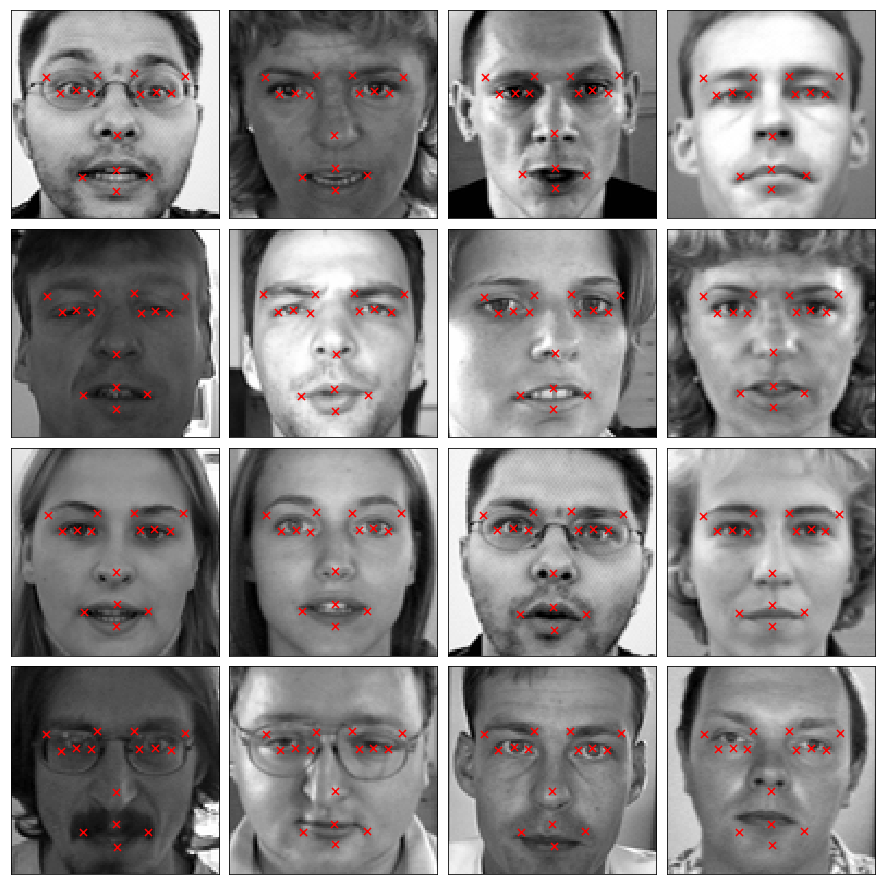

In [12]:
fig = pyplot.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X_test[i], y_pred[i], ax)
    
pyplot.show()

In [22]:
X_test, _ = load(test=True)
submission_csv_path = prepare_submission(X_test, "20171207_13:52:20_cnn_with_saver", 900)
print("submission csv is saved at: {}".format(submission_csv_path))

INFO:tensorflow:Restoring parameters from /Users/chang12/Projects/kaggle/facial-keypoint-detection/checkpoints/20171207_13:52:20_cnn_with_saver/00900/ckpt
submission csv is saved at: /Users/chang12/Projects/kaggle/facial-keypoint-detection/submissions/20171207_13:52:20_cnn_with_saver_00900.csv
